pip install tensorflow keras deap  matplotlib


In [1]:
!pip install tensorflow keras deap  matplotlib



# Importar as bibliotecas:


In [8]:
import tensorflow as tf # biblioteca TensorFlow é utilizada para a construção de
# modelos de redes neurais
from tensorflow.keras import datasets, layers, models, Input # importa as
#bibliotecas necessárias para a construção do modelo
from deap import base, creator, tools # biblioteca DEAP é utilizada para a
# implementação de algoritmos evolutivos
import numpy as np # numpy é uma biblioteca utilizada para manipulação de arrays
# e matrizes, servindo, neste caso, para a manipulação de dados
import matplotlib.pyplot as plt # matplotlib é uma biblioteca utilizada para a
#plotagem de gráficos
from tensorflow.keras.utils import plot_model # plot_model recebe como argumento
# o modelo que se deseja plotar, salvando-o em um arquivo .png
from IPython.display import clear_output


# Verificar GPU

In [9]:


print("Versão do TensorFlow:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

Versão do TensorFlow: 2.17.0
GPU disponível: []


# Preparar os dados (usando MNIST):


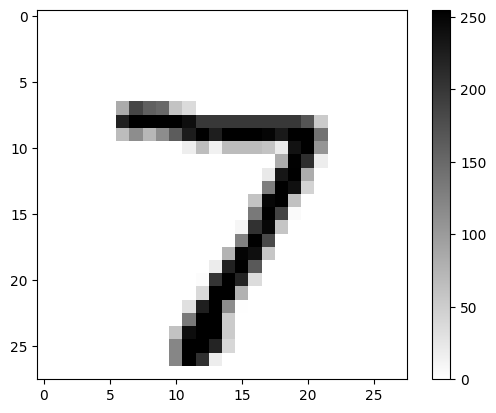

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
x_train normalizado: (60000, 28, 28)
x_train com mais uma dimensão para canais: (60000, 28, 28, 1)


In [10]:


# Carregar e preparar o dataset MNIST, que contém imagens de dígitos escritos à
# mão (e suas labels) e é comumente utilizado para testar algoritmos de classificação
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data() # x representa
# as imagens e y as labels; mnist é um dataset já disponível no TensorFlow

# Plotar uma imagem do dataset MNIST
plt.figure()
plt.imshow(x_test[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Verificar o formato dos dados
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)


# Normalizar os dados para o intervalo [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0 # 255 é o valor máximo de um pixel
print("x_train normalizado:", x_train.shape)

# Adicionar uma dimensão para canais (necessário para a CNN)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print("x_train com mais uma dimensão para canais:", x_train.shape)

# Codificar as labels em vetores binários (one-hot encoding, equivalente ao
#OneHotEncoder, do sklearn); 10 é o número de classes, ou seja, dígitos de 0 a 9
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


# Definir a função para criar a CNN:


In [11]:
class DynamicPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, generation, epoch):
        self.generation = generation
        self.epoch = epoch
        self.batch_losses = []
        self.batch_accuracies = []
        self.epoch_losses = []
        self.epoch_accuracies = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_accuracies.append(logs['accuracy'])
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.batch_losses, label='Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Generation {self.generation} - Epoch {self.epoch} - Batch {batch}')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.batch_accuracies, label='Accuracy')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.title(f'Generation {self.generation} - Epoch {self.epoch} - Batch {batch}')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_losses.append(logs['loss'])
        self.epoch_accuracies.append(logs['accuracy'])
        print(f"Epoch {epoch + 1} completed.")
        print(f" - Loss: {logs['loss']:.4f}")
        print(f" - Accuracy: {logs['accuracy']:.4f}")
        print(f" - Validation Loss: {logs['val_loss']:.4f}")
        print(f" - Validation Accuracy: {logs['val_accuracy']:.4f}")

def create_cnn(hp):
    """
    Cria uma CNN com base nos hiperparâmetros fornecidos.

    Args:
        hp (dict): Dicionário contendo os hiperparâmetros.

    Returns:
        model (tf.keras.Model): O modelo CNN compilado.
    """
    model = models.Sequential()
    model.add(Input(shape=(28, 28, 1)))  # Definir a forma de entrada
    model.add(layers.Conv2D(hp['filters'], (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp['filters']*2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp['filters']*2, (3, 3), activation='relu'))
    model.add(layers.Flatten())  # Flatten para transformar a saída em um vetor
    model.add(layers.Dense(hp['dense_units'], activation='relu'))  # Camada densa
    model.add(layers.Dropout(hp['dropout_rate']))  # Camada de dropout
    model.add(layers.Dense(10, activation='softmax'))  # Camada de saída

    model.compile(optimizer=hp['optimizer'],
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Definir a função de avaliação:


In [12]:
def evaluate(individual, generation, epoch):
    hp = {
        'filters': int(individual[0]),
        'dense_units': int(individual[1]),
        'dropout_rate': individual[2],
        'optimizer_name': individual[3],
        'batch_size': int(individual[4]),
        'learning_rate': individual[5]
    }

    if hp['optimizer_name'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    elif hp['optimizer_name'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp['learning_rate'])
    elif hp['optimizer_name'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp['learning_rate'])
    else:
        raise ValueError(f"Unknown optimizer: {hp['optimizer_name']}")

    hp['optimizer'] = optimizer

    model = create_cnn(hp)

    dynamic_plot_callback = DynamicPlotCallback(generation=generation, epoch=epoch)

    history = model.fit(
        x_train, y_train,
        epochs=1,  # Treinar uma época de cada vez para atualizar o gráfico dinamicamente
        batch_size=hp['batch_size'],
        validation_data=(x_test, y_test),
        verbose=0,
        callbacks=[dynamic_plot_callback]
    )

    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy,

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 32, 64)
toolbox.register("attr_dense", np.random.randint, 64, 128)
toolbox.register("attr_dropout", np.random.uniform, 0.2, 0.5)
toolbox.register("attr_optimizer", np.random.choice, ['adam', 'sgd', 'rmsprop'])
toolbox.register("attr_batch_size", np.random.choice, [32, 64])
toolbox.register("attr_learning_rate", np.random.uniform, 1e-4, 1e-3)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_dense, toolbox.attr_dropout,
                  toolbox.attr_optimizer, toolbox.attr_batch_size, toolbox.attr_learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=10)

# Configurar o algoritmo genético:


# Executar o algoritmo genético:


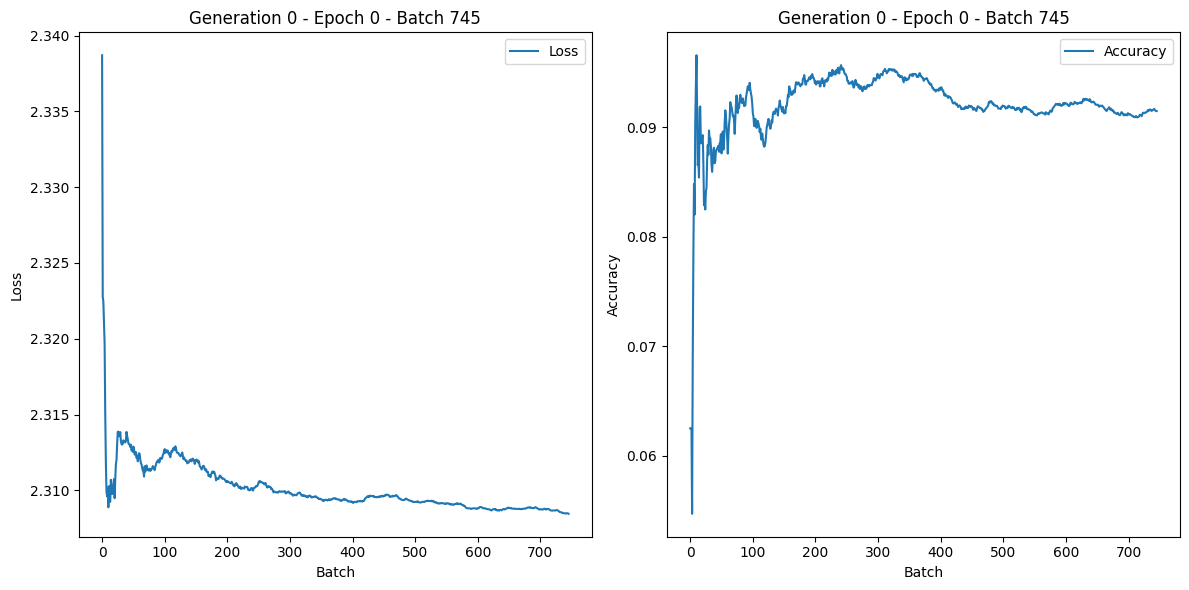

In [13]:
# Definir os parâmetros do algoritmo genético
NGEN = 3
CXPB = 0.5
MUTPB = 0.2

gen_accuracies = []
best_accuracies = []

for gen in range(NGEN):
    print(f"-- Geração {gen} --")
    current_generation = gen

    for epoch in range(2):
        current_epoch = epoch

        fitnesses = list(map(lambda ind: toolbox.evaluate(ind, current_generation, current_epoch), population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        accuracies = [ind.fitness.values[0] for ind in population]
        gen_accuracies.append(np.mean(accuracies))
        best_accuracies.append(max(accuracies))

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.rand() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if np.random.rand() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(lambda ind: toolbox.evaluate(ind, current_generation, current_epoch), invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

best_ind = tools.selBest(population, 1)[0]
print(f"Melhor indivíduo: {best_ind}, Acurácia: {best_ind.fitness.values}")

plt.figure(figsize=(10, 5))
plt.plot(gen_accuracies, label='Acurácia Média')
plt.plot(best_accuracies, label='Melhor Acurácia')
plt.xlabel('Geração')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia ao Longo das Gerações')
plt.show()

best_hp = {
    'filters': int(best_ind[0]),
    'dense_units': int(best_ind[1]),
    'optimizer': best_ind[2],
    'dropout_rate': best_ind[3],
    'batch_size': best_ind[4],
    'learning_rate': best_ind[5]
}
best_model = create_cnn(best_hp)

plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='best_model.png')